In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse
import pandas as pd
from progressbar import ProgressBar
import scipy

import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.layers import Dense, Input, Conv1D, MaxPooling1D, Reshape, Flatten, GlobalMaxPooling1D, Layer
from tensorflow.keras.layers import Dropout, ReLU
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MeanSquaredError
from keras.initializers import glorot_normal
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

from tensorflow.keras import Model
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as rmse

plt.rcParams.update({'font.size': 8})

In [4]:
def math_fun(x):
    x1=x[:,0]
    x2=x[:,1]
    g=((1.5+x1)**2+4)*(1.5+x2)/20-np.sin(5*(1.5+x1)/2)
    return g

### Prepare the training, testing and OOD data for the ML model
def make_data():
    mean_c1 = (8, 3.5)
    cov_c1 = [[0.4, -0.32], [-0.32, 0.4]]
    c1_sample_no = 500
    x_c1 = np.random.multivariate_normal(mean_c1, cov_c1, (c1_sample_no, 1)).reshape(c1_sample_no, 2)

    mean_c2 = (-2.5, -2.5)
    cov_c2 = [[0.4, -0.32], [-0.32, 0.4]]
    c2_sample_no = 500
    x_c2 = np.random.multivariate_normal(mean_c2, cov_c2, (c2_sample_no, 1)).reshape(c2_sample_no, 2)

    mean_ood = (-10, -7.5)
    cov_ood = [[0.2, -0.16], [-0.16, 0.2]]
    ood_sample_no = 200
    x_ood = np.random.multivariate_normal(mean_ood, cov_ood, (ood_sample_no, 1)).reshape(ood_sample_no, 2) 

    y_c1 = math_fun(x_c1).reshape(-1, 1)
    y_c2 = math_fun(x_c2).reshape(-1, 1)
    y_ood = math_fun(x_ood).reshape(-1, 1)

    ## Create train and test data for each cluster of data
    random_state = 1
    x_c1_train, x_c1_test, y_c1_train, y_c1_test = train_test_split(x_c1, y_c1, test_size=0.2, random_state=random_state)
    x_c2_train, x_c2_test, y_c2_train, y_c2_test = train_test_split(x_c2, y_c2, test_size=0.2, random_state=random_state)

    x_train = np.concatenate((x_c1_train, x_c2_train), axis = 0)
    x_test = np.concatenate((x_c1_test, x_c2_test), axis = 0)
    y_train = np.concatenate((y_c1_train, y_c2_train), axis = 0)
    y_test = np.concatenate((y_c1_test, y_c2_test), axis = 0)

    plt.figure(figsize=(10, 10))
    plt.scatter(x_c1_train[:, 0], x_c1_train[:, 1], color = 'red', marker = '+', label='1st cluster train')
    plt.scatter(x_c1_test[:, 0], x_c1_test[:, 1], color = 'red', marker = 's', label='1st cluster test')

    plt.scatter(x_c2_train[:, 0], x_c2_train[:, 1], color = 'blue', marker = '+', label='2nd cluster train')
    plt.scatter(x_c2_test[:, 0], x_c2_test[:, 1], color = 'blue', marker = 's', label='2nd cluster test')

    plt.scatter(x_ood[:, 0], x_ood[:, 1], color = 'purple', label = 'OOD samples')

    plt.xlabel('X1', fontsize=22, fontweight='bold')
    plt.ylabel('X2', fontsize=22, fontweight='bold')
    plt.xticks(fontsize=18, fontweight='bold')
    plt.yticks(fontsize=18, fontweight='bold')

    plt.legend(fontsize=20)
    plt.axis('equal')
    plt.xlim([-15, 15])
    plt.ylim([-15, 15])
    plt.tight_layout()
    plt.savefig('train_test_data.pdf')

    n_meshes = 200
    x1, x2 = np.meshgrid(np.linspace(-15, 15, n_meshes), np.linspace(-15, 15, n_meshes))
    x_mesh = np.concatenate((x1.reshape(-1, 1), x2.reshape(-1, 1)), axis = 1)
    y_mesh = math_fun(x_mesh).reshape(-1, 1).flatten()

    return x_train, x_test, y_train, y_test, x_ood, y_ood, x_mesh, y_mesh

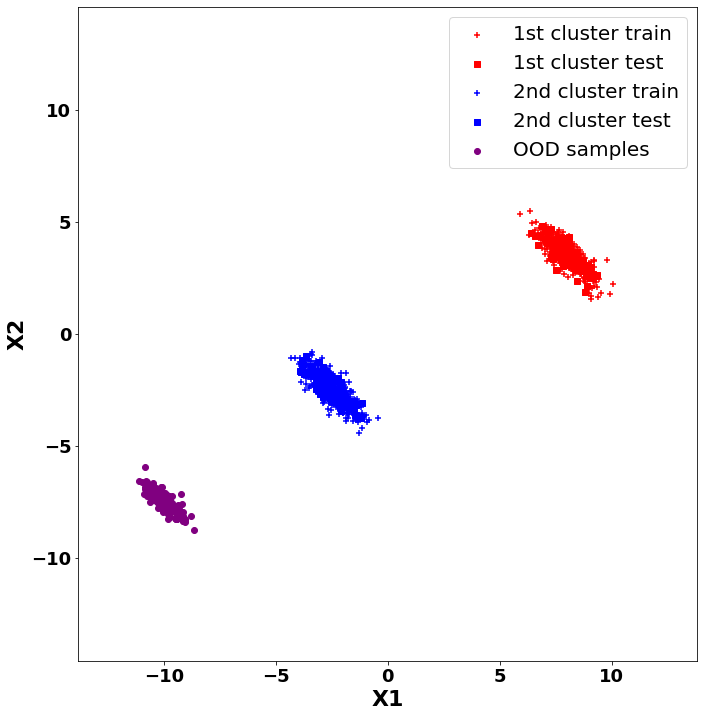

In [5]:
np.random.seed(1)
x_train, x_test, y_train, y_test, x_ood, y_ood, x_mesh, y_mesh = make_data()

In [6]:
scalerX, scalerY = MinMaxScaler(), MinMaxScaler()
x_train_norm, y_train_norm = scalerX.fit_transform(x_train), scalerY.fit_transform(y_train)
x_test_norm, y_test_norm = scalerX.transform(x_test), scalerY.transform(y_test)
x_ood_norm, y_ood_norm   = scalerX.transform(x_ood), scalerY.transform(y_ood)
x_mesh_norm = scalerX.transform(x_mesh)
y_mesh_norm = scalerY.transform(y_mesh.reshape(-1, 1))

In [7]:
def plot_uncertainty_map(x_train, x_ood, x_mesh, output_std, filename, spectral_normalization = False, contour=False):
    std_scaled = output_std/max(output_std)

    plt.figure(figsize=(10, 10))
    plt.rcParams['axes.xmargin'] = 0
    plt.rcParams['axes.ymargin'] = 0
    plt.scatter(x_mesh[:, 0], x_mesh[:, 1], rasterized = True, c = std_scaled, cmap = plt.get_cmap('viridis'))
    
    if spectral_normalization:
        cbar = plt.colorbar(fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=28)
        
    plt.scatter(x_train[:, 0], x_train[:, 1], color = 'magenta', s = 20, alpha = 0.7, label = 'Training')
    plt.scatter(x_ood[:, 0], x_ood[:, 1], color = 'red', s = 20, alpha = 0.7, label = 'OOD')

    if contour:
        n = np.ceil(np.sqrt(len(std_scaled))).astype(int)
        h = std_scaled.reshape(n, n)
        contours = plt.contour(x_mesh[:, 0].reshape(n, n), x_mesh[:, 1].reshape(n, n), h)
        plt.clabel(contours, inline=True, fontsize=12)

        filename += '_with_contour'

    plt.legend(fontsize=20, loc=4)
    plt.xlabel(r'$x_1$', fontsize=40, fontweight='bold')
    plt.ylabel(r'$x_2$', fontsize=40, fontweight='bold')
    plt.xticks(fontsize=36, fontweight='bold')
    plt.yticks(fontsize=36, fontweight='bold')

    plt.tight_layout()
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.savefig(filename+'.png')

## Gaussian Process Regression

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

model_GP = GaussianProcessRegressor(kernel=1 * RBF(length_scale=0.001, length_scale_bounds=(1e-3, 1e2)), 
                                    n_restarts_optimizer=10)
model_GP.fit(x_train_norm, y_train_norm)
#  For nu=inf, the kernel becomes equivalent to the RBF kernel and for nu=0.5 to the absolute exponential kernel. 
#  Important intermediate values are nu=1.5 (once differentiable functions) and 
#  nu=2.5 (twice differentiable functions).

/home/venkat/anaconda3/envs/py3/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=0.001),
                         n_restarts_optimizer=10)

train error (RMSE): 284.0198841136143


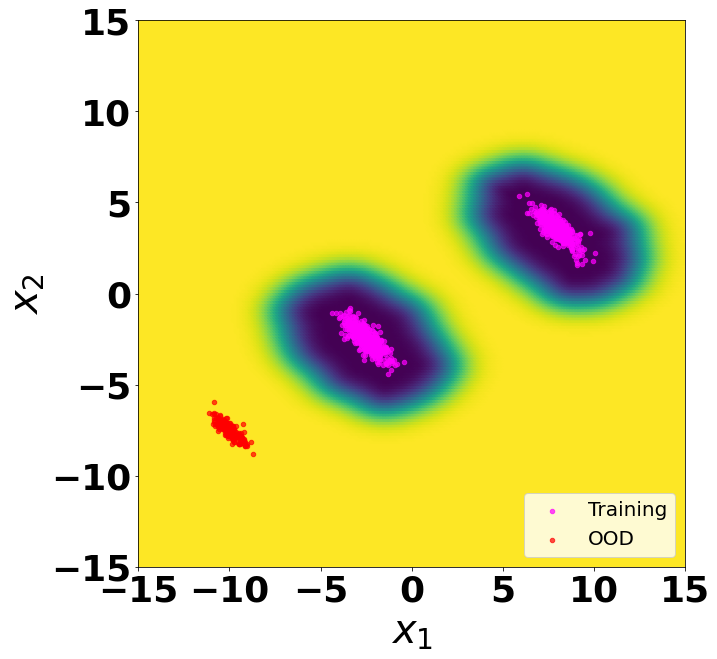

In [9]:
print('train error (RMSE):',  rmse(y_train, model_GP.predict(x_train, return_std=False)))
output, output_std = model_GP.predict(x_mesh_norm, return_std=True)
plot_uncertainty_map(x_train, x_ood, x_mesh, output_std, 'GP', False, False)

## General model for all

In [10]:
# loss function and new custom layer to give mean and standard deviation
# Inspired from https://medium.com/@albertoarrigoni/paper-review-code-deep-ensembles-nips-2017-c5859070b8ce
def custom_loss(sigma):
    def gaussian_loss(y_true, y_pred):
        return tf.reduce_mean(0.5*tf.math.log((sigma)) + 0.5*tf.math.divide(tf.math.square(y_true - y_pred), (sigma))) + 1e-6
    return gaussian_loss
class GaussianLayer(Layer):
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(GaussianLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.kernel_1 = self.add_weight(name='kernel_1', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.kernel_2 = self.add_weight(name='kernel_2', 
                                      shape=(10, self.output_dim),
                                      initializer=glorot_normal(),
                                      trainable=True)
        self.bias_1 = self.add_weight(name='bias_1',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        self.bias_2 = self.add_weight(name='bias_2',
                                    shape=(self.output_dim, ),
                                    initializer=glorot_normal(),
                                    trainable=True)
        super(GaussianLayer, self).build(input_shape) 
    def call(self, x):
        output_mu  = K.dot(x, self.kernel_1) + self.bias_1
        output_sig = K.dot(x, self.kernel_2) + self.bias_2
        output_sig_pos = K.log(1 + K.exp(output_sig)) + 1e-06  
        return [output_mu, output_sig_pos]
    def compute_output_shape(self, input_shape):
        return [(input_shape[0], self.output_dim), (input_shape[0], self.output_dim)]
    
    
def generate_trained_model(num_hidden, num_layers, trainX, trainY, nepochs, actfn = 'relu', 
                           dropout_bool = 0, dropout_rate = 0.2, GL_bool = 0):
    n_inp_features = np.shape(trainX)[1]
    feature_input = Input(shape=(n_inp_features,), name="feature_input_layer")
    x = Dense(10, activation = actfn)(feature_input)
    for _ in range(num_layers):
        x = Dense(num_hidden, activation = actfn)(x)
        x1 = Dense(num_hidden, activation = actfn)(x)
        x = x1 + x
        if dropout_bool:
            x = Dropout(dropout_rate)(x)
    x = Dense(10, activation = actfn)(x)
    if GL_bool:
        mu, sigma = GaussianLayer(1, name='main_output')(x)
        model = Model(feature_input, mu)
        model.compile(loss=custom_loss(sigma), optimizer='adam')
    else:
        mu = Dense(1, name='main_output')(x)
        model = Model(feature_input, mu)
        model.compile(loss='mean_squared_error', optimizer='adam')
        
#     model.summary()
    history = model.fit(trainX, trainY, shuffle=True, epochs=nepochs, verbose = 0)
    
    layer_name = 'main_output' # Where to extract the Gaussian output from. 
    
    if dropout_bool:
        get_intermediate = K.function([model.layers[0].input, K.learning_phase()],
                                  [model.get_layer(layer_name).output])
    else:
        get_intermediate = K.function(inputs=[model.input], outputs=model.get_layer(layer_name).output)
    return get_intermediate, model.count_params()

def get_ensemble(df, UQmodelcode, nmodels_select):
    mu_cols = [UQmodelcode + "_mu_"+str(i) for i in range(nmodels_select)]
    sigma_cols = [UQmodelcode + "_sigma_"+str(i) for i in range(nmodels_select)]
    
    mu_eff = df[mu_cols].mean(axis=1)
    sigma_eff =  np.sqrt(np.mean(df[mu_cols]**2, axis = 1)
                         + np.mean(df[sigma_cols]**2, axis = 1)
                         - mu_eff**2)
    df[UQmodelcode+"_mu_eff"] = mu_eff
    df[UQmodelcode+"_sigma_eff"] = sigma_eff
    return df

## MC Dropout
### Relu activation fn

In [13]:
hidden_cases = [10, 50, 100]
layers_cases = [2, 5, 10]
epochs_cases = [400,2000]

# for num_hidden in hidden_cases:
#     print(num_hidden)
#     for num_layers in layers_cases:
#         for nepochs in epochs_cases:
#             myfunc, nparam = generate_trained_model(num_hidden, num_layers, x_train_norm, 
#                                                     y_train_norm, nepochs, actfn = 'relu', 
#                                                     dropout_bool = 1, dropout_rate = 0.2, GL_bool = 0)
#             niter = 20
#             MC_output = np.zeros((len(x_mesh),niter))
#             for i in range(niter):
#                 MC_output[:,i] = scalerY.inverse_transform(myfunc((x_mesh_norm,1))[0])[:,0]
#             plot_uncertainty_map(x_train, x_ood, x_mesh, np.std(MC_output, axis = 1), 
#                                  f'figs/MCD_H{num_hidden}_L{num_layers}_E{nepochs}', False, False)

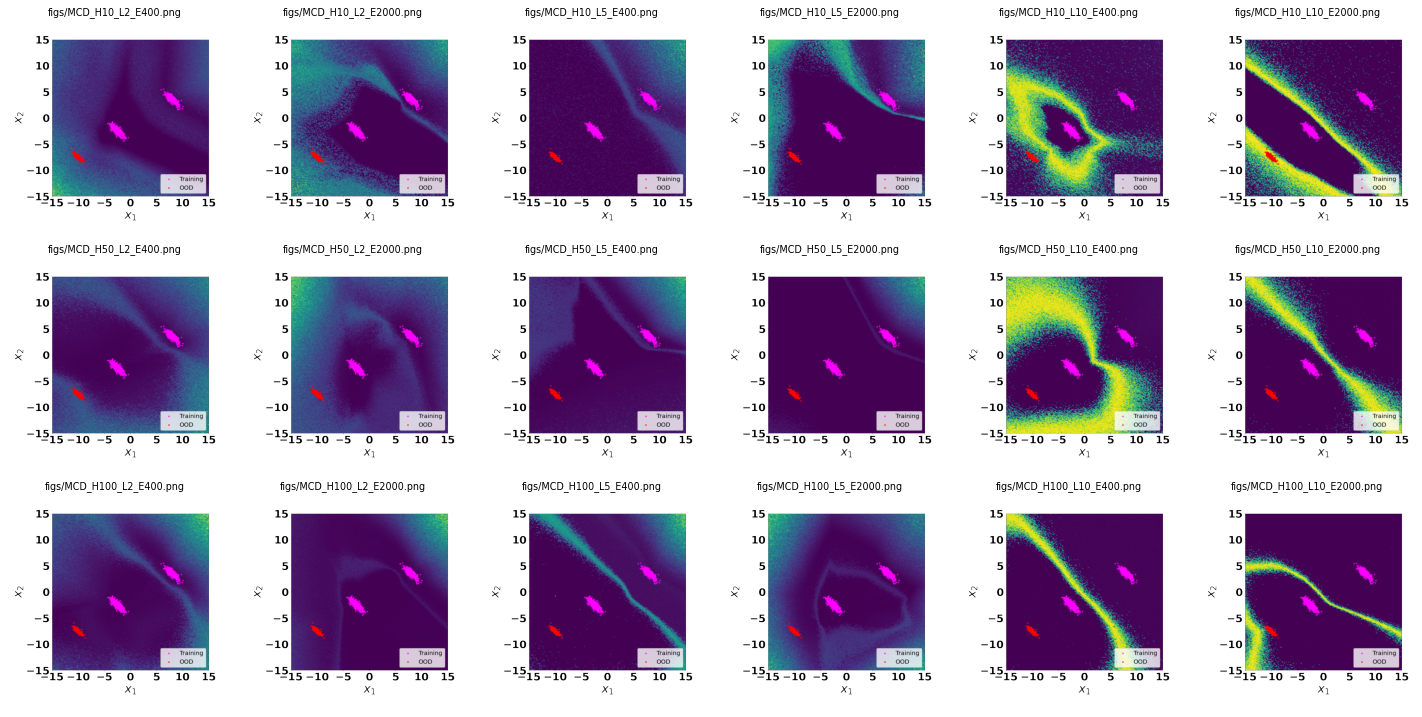

In [14]:
fig, axs = plt.subplots(3, 6, figsize=(20,10))
axs = axs.flatten()
count = 0
for num_hidden in hidden_cases:
    for num_layers in layers_cases:
        for nepochs in epochs_cases:
            filename = f'figs/MCD_H{num_hidden}_L{num_layers}_E{nepochs}.png'
            im = img.imread(filename)
            axs[count].imshow(im)
            axs[count].set(title=filename)
            axs[count].axis('off')
            count = count+1
            
fig.tight_layout()
plt.savefig('MCD_cumulative_relu.pdf')

## MC Dropout
### Sigmoid activation fn

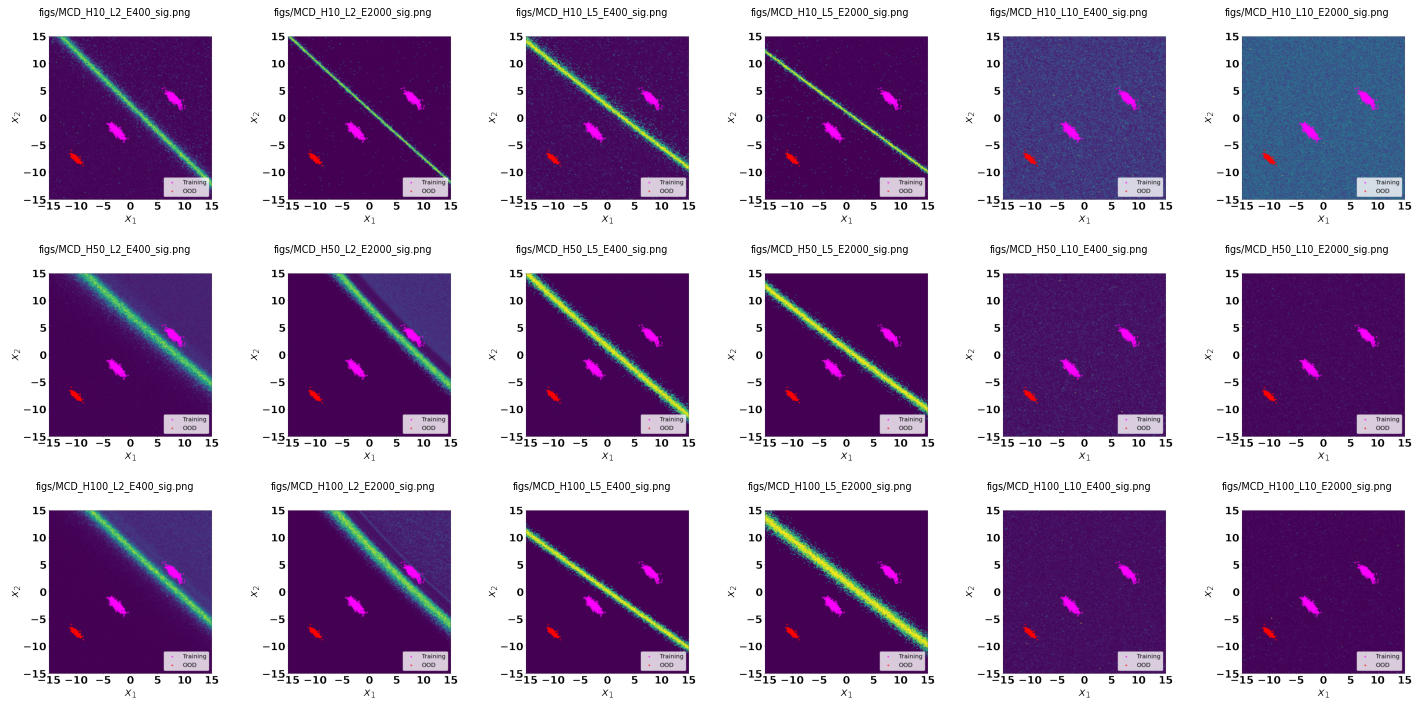

In [15]:
# for num_hidden in hidden_cases:
#     print(num_hidden)
#     for num_layers in layers_cases:
#         for nepochs in epochs_cases:
#             myfunc, nparam = generate_trained_model(num_hidden, num_layers, x_train_norm, 
#                                                     y_train_norm, nepochs, actfn = 'sigmoid', 
#                                                     dropout_bool = 1, dropout_rate = 0.2, GL_bool = 0)
#             niter = 20
#             MC_output = np.zeros((len(x_mesh),niter))
#             for i in range(niter):
#                 MC_output[:,i] = scalerY.inverse_transform(myfunc((x_mesh_norm,1))[0])[:,0]
#             plot_uncertainty_map(x_train, x_ood, x_mesh, np.std(MC_output, axis = 1), 
#                                  f'figs/MCD_H{num_hidden}_L{num_layers}_E{nepochs}_sig', False, False)

fig, axs = plt.subplots(3, 6, figsize=(20,10))
axs = axs.flatten()
count = 0
for num_hidden in hidden_cases:
    for num_layers in layers_cases:
        for nepochs in epochs_cases:
            filename = f'figs/MCD_H{num_hidden}_L{num_layers}_E{nepochs}_sig.png'
            im = img.imread(filename)
            axs[count].imshow(im)
            axs[count].set(title=filename)
            axs[count].axis('off')
            count = count+1
            
fig.tight_layout()
plt.savefig('MCD_cumulative_sigmoid.pdf')

## MC Dropout
### tanh activation fn

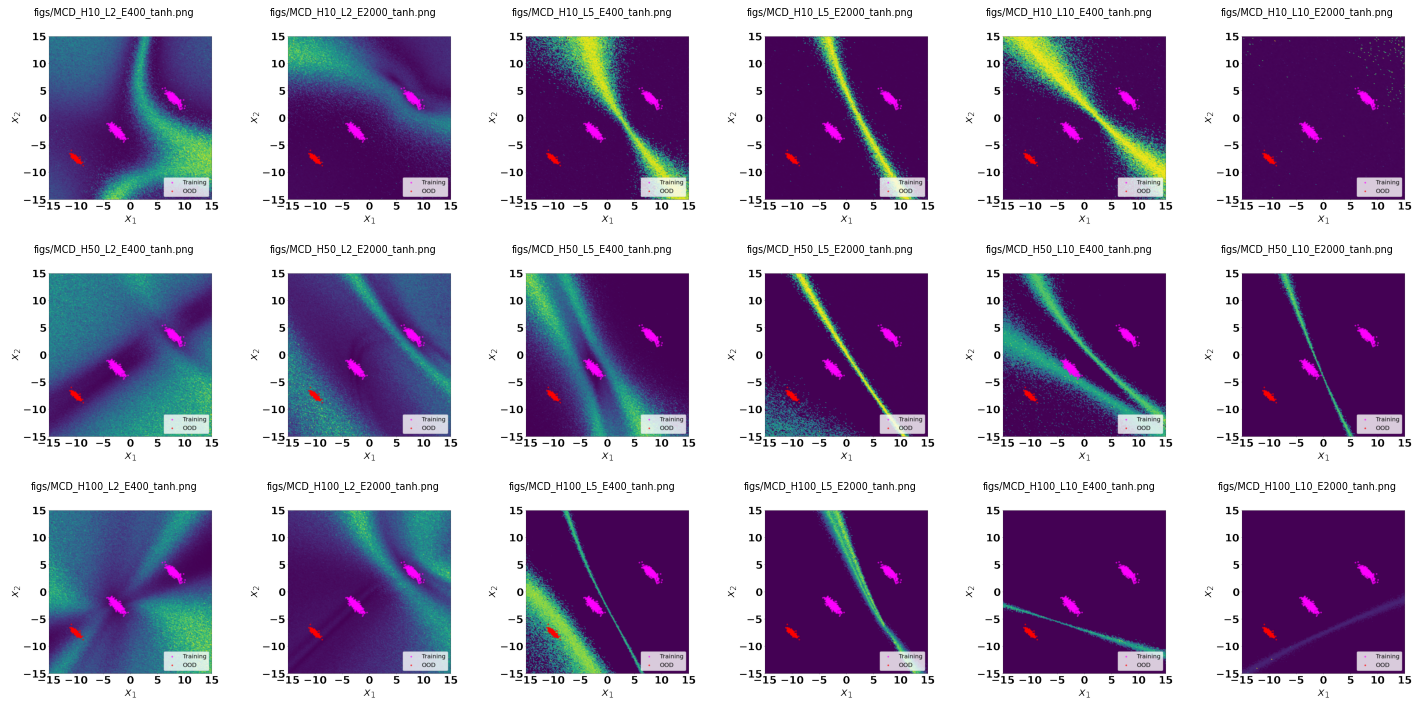

In [16]:
# for num_hidden in hidden_cases:
#     print(num_hidden)
#     for num_layers in layers_cases:
#         for nepochs in epochs_cases:
#             myfunc, nparam = generate_trained_model(num_hidden, num_layers, x_train_norm, 
#                                                     y_train_norm, nepochs, actfn = 'tanh', 
#                                                     dropout_bool = 1, dropout_rate = 0.2, GL_bool = 0)
#             niter = 20
#             MC_output = np.zeros((len(x_mesh),niter))
#             for i in range(niter):
#                 MC_output[:,i] = scalerY.inverse_transform(myfunc((x_mesh_norm,1))[0])[:,0]
#             plot_uncertainty_map(x_train, x_ood, x_mesh, np.std(MC_output, axis = 1), 
#                                  f'figs/MCD_H{num_hidden}_L{num_layers}_E{nepochs}_tanh', False, False)

fig, axs = plt.subplots(3, 6, figsize=(20,10))
axs = axs.flatten()
count = 0
for num_hidden in hidden_cases:
    for num_layers in layers_cases:
        for nepochs in epochs_cases:
            filename = f'figs/MCD_H{num_hidden}_L{num_layers}_E{nepochs}_tanh.png'
            im = img.imread(filename)
            axs[count].imshow(im)
            axs[count].set(title=filename)
            axs[count].axis('off')
            count = count+1
            
fig.tight_layout()
plt.savefig('MCD_cumulative_tanh.pdf')

## Deep Ensemble
### Relu activation

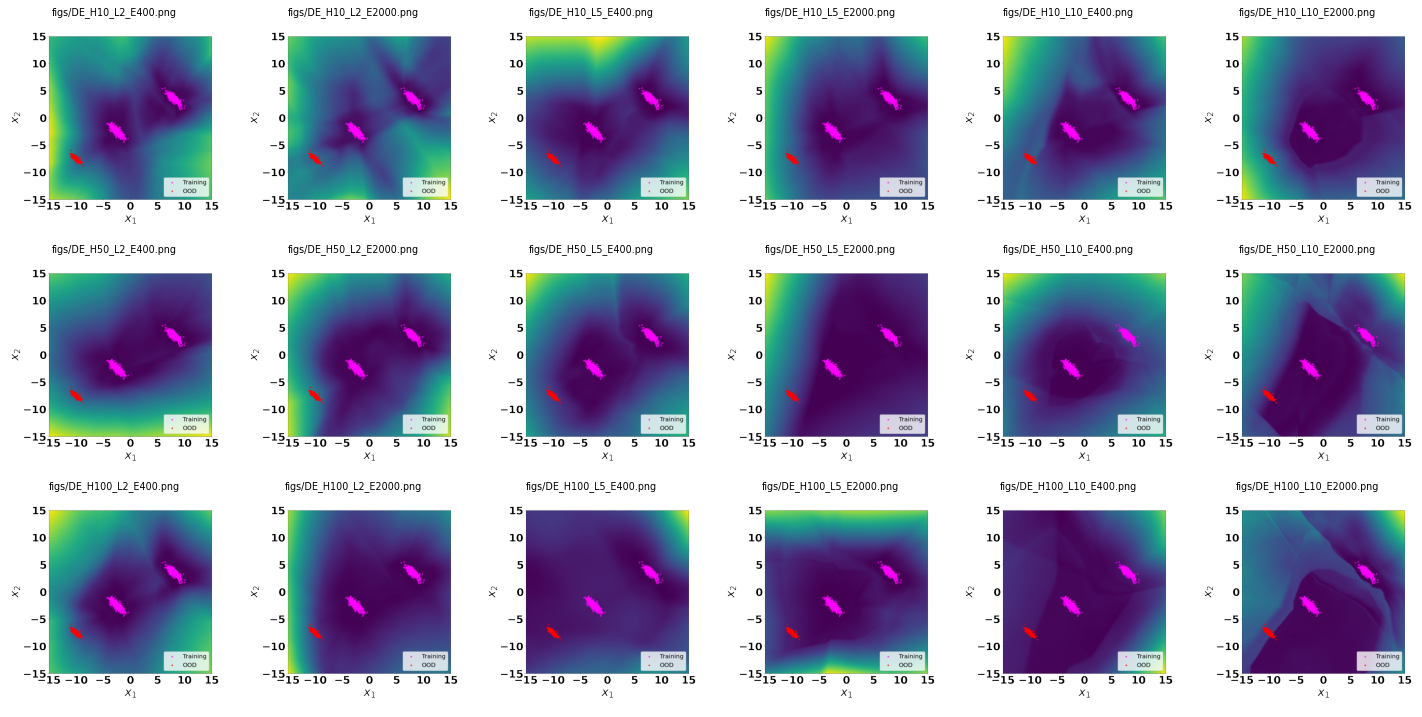

In [17]:
hidden_cases = [10, 50, 100]
layers_cases = [2, 5, 10]
epochs_cases = [400,2000]

# Allparams=[]

# prediction_fns, train_rmse = [], []
# nmodels = 5 # models in ensemble

# for num_hidden in hidden_cases:
#     for num_layers in layers_cases:
#         for nepochs in epochs_cases:
#             pbar = ProgressBar()
#             prediction_fns, train_rmse = [], []
#             for i in pbar(range(nmodels)): # for the ensemble of nmodels
#                 myfunc, nparam = generate_trained_model(num_hidden, num_layers, x_train_norm, 
#                                                         y_train_norm, nepochs, actfn = 'relu', 
#                                                         dropout_bool = 0, dropout_rate = 0, GL_bool = 1)
#                 prediction_fns.append(myfunc)
                
#             Allparams.append(nparam) # storing the number of parameters
            
#             result_df = pd.DataFrame(x_mesh, columns = ['x1', 'x2'])
#             for i in range(nmodels):
#                 result_df["DE_mu_"+str(i)] = scalerY.inverse_transform(prediction_fns[i](x_mesh_norm)[0])
#                 result_df["DE_sigma_"+str(i)] = scalerY.inverse_transform(np.sqrt(prediction_fns[i](x_mesh_norm)[1]))
            
#             result_df = get_ensemble(result_df, "DE", nmodels)
#             plot_uncertainty_map(x_train, x_ood, x_mesh, result_df['DE_sigma_eff'], 
#                                  f'figs/DE_H{num_hidden}_L{num_layers}_E{nepochs}', False, False)
            
fig, axs = plt.subplots(3, 6, figsize=(20,10))
axs = axs.flatten()
count = 0
for num_hidden in hidden_cases:
    for num_layers in layers_cases:
        for nepochs in epochs_cases:
            filename = f'figs/DE_H{num_hidden}_L{num_layers}_E{nepochs}.png'
            im = img.imread(filename)
            axs[count].imshow(im)
            axs[count].set(title=filename)
            axs[count].axis('off')
            count = count+1
            
fig.tight_layout()
plt.savefig('DE_cumulative_relu.pdf')

## Deep Ensemble
### Sigmoid activation

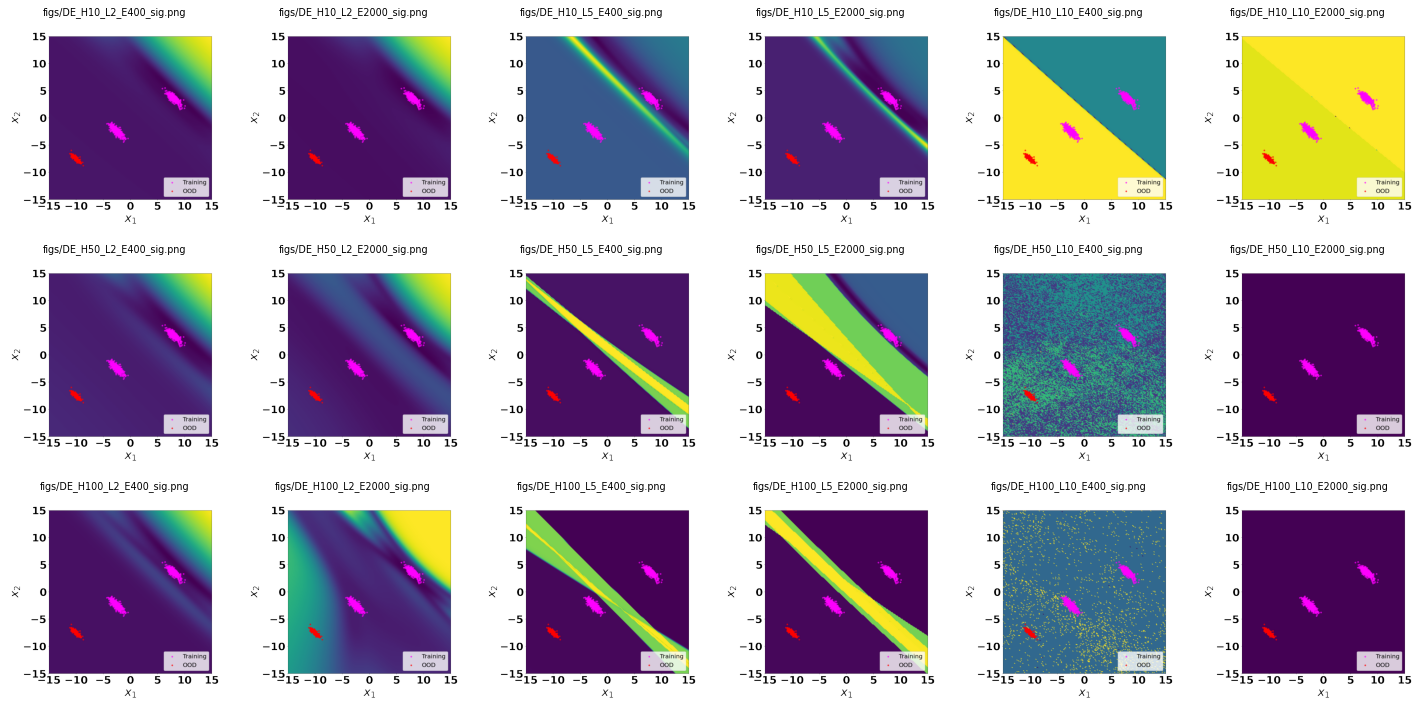

In [18]:
# for num_hidden in hidden_cases:
#     for num_layers in layers_cases:
#         for nepochs in epochs_cases:
#             pbar = ProgressBar()
#             prediction_fns, train_rmse = [], []
#             for i in pbar(range(nmodels)): # for the ensemble of nmodels
#                 myfunc, nparam = generate_trained_model(num_hidden, num_layers, x_train_norm, 
#                                                         y_train_norm, nepochs, actfn = 'sigmoid', 
#                                                         dropout_bool = 0, dropout_rate = 0, GL_bool = 1)
#                 prediction_fns.append(myfunc)
                
#             Allparams.append(nparam) # storing the number of parameters
            
#             result_df = pd.DataFrame(x_mesh, columns = ['x1', 'x2'])
#             for i in range(nmodels):
#                 result_df["DE_mu_"+str(i)] = scalerY.inverse_transform(prediction_fns[i](x_mesh_norm)[0])
#                 result_df["DE_sigma_"+str(i)] = scalerY.inverse_transform(np.sqrt(prediction_fns[i](x_mesh_norm)[1]))
            
#             result_df = get_ensemble(result_df, "DE", nmodels)
#             plot_uncertainty_map(x_train, x_ood, x_mesh, result_df['DE_sigma_eff'], 
#                                  f'figs/DE_H{num_hidden}_L{num_layers}_E{nepochs}_sig', False, False)
            
fig, axs = plt.subplots(3, 6, figsize=(20,10))
axs = axs.flatten()
count = 0
for num_hidden in hidden_cases:
    for num_layers in layers_cases:
        for nepochs in epochs_cases:
            filename = f'figs/DE_H{num_hidden}_L{num_layers}_E{nepochs}_sig.png'
            im = img.imread(filename)
            axs[count].imshow(im)
            axs[count].set(title=filename)
            axs[count].axis('off')
            count = count+1
            
fig.tight_layout()
plt.savefig('DE_cumulative_sigmoid.pdf')

## Deep Ensemble
### Tanh activation

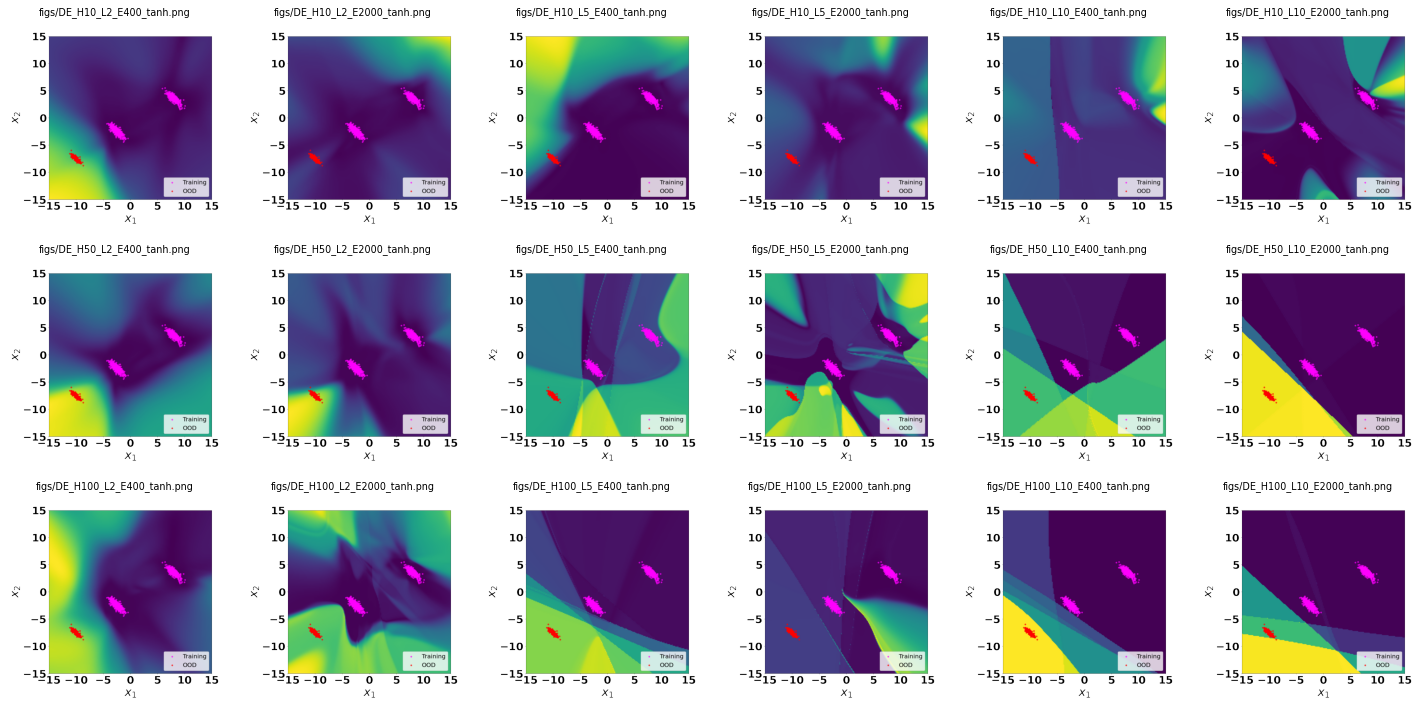

In [19]:
# for num_hidden in hidden_cases:
#     for num_layers in layers_cases:
#         for nepochs in epochs_cases:
#             pbar = ProgressBar()
#             prediction_fns, train_rmse = [], []
#             for i in pbar(range(nmodels)): # for the ensemble of nmodels
#                 myfunc, nparam = generate_trained_model(num_hidden, num_layers, x_train_norm, 
#                                                         y_train_norm, nepochs, actfn = 'tanh', 
#                                                         dropout_bool = 0, dropout_rate = 0, GL_bool = 1)
#                 prediction_fns.append(myfunc)
                
#             Allparams.append(nparam) # storing the number of parameters
            
#             result_df = pd.DataFrame(x_mesh, columns = ['x1', 'x2'])
#             for i in range(nmodels):
#                 result_df["DE_mu_"+str(i)] = scalerY.inverse_transform(prediction_fns[i](x_mesh_norm)[0])
#                 result_df["DE_sigma_"+str(i)] = scalerY.inverse_transform(np.sqrt(prediction_fns[i](x_mesh_norm)[1]))
            
#             result_df = get_ensemble(result_df, "DE", nmodels)
#             plot_uncertainty_map(x_train, x_ood, x_mesh, result_df['DE_sigma_eff'], 
#                                  f'figs/DE_H{num_hidden}_L{num_layers}_E{nepochs}_tanh', False, False)
            
fig, axs = plt.subplots(3, 6, figsize=(20,10))
axs = axs.flatten()
count = 0
for num_hidden in hidden_cases:
    for num_layers in layers_cases:
        for nepochs in epochs_cases:
            filename = f'figs/DE_H{num_hidden}_L{num_layers}_E{nepochs}_tanh.png'
            im = img.imread(filename)
            axs[count].imshow(im)
            axs[count].set(title=filename)
            axs[count].axis('off')
            count = count+1
            
fig.tight_layout()
plt.savefig('DE_cumulative_tanh.pdf')